In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rcParams  ## run command settings for plotting
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, roc_curve, roc_auc_score, recall_score, f1_score

In [2]:

config = {
    "mathtext.fontset":'stix',
    "font.family":'serif',
    "font.serif": ['SimHei'],
    "font.size": 10,   # 字号，大家自行调节
    'axes.unicode_minus': False # 处理负号，即-号
}
rcParams.update(config)  ## 设置画图的一些参数

In [3]:
## 读取数据
path = r'D:\d2l-zh\machine learning\ex2data1.txt'
import pandas as pd
data = pd.read_csv(path) ## data 是dataframe 的数据类型
data.head(5)

,34.62365962451697,78.0246928153624,0
0,30.286711,43.894998,0
1,35.847409,72.902198,0
2,60.182599,86.308552,1
3,79.032736,75.344376,1
4,45.083277,56.316372,0


In [4]:
data.describe()

,34.62365962451697,78.0246928153624,0
count,99.000000,99.000000,99.000000
mean,65.957614,66.102779,0.606061
std,19.302009,18.638875,0.491108
min,30.058822,30.603263,0.000000
25%,51.297736,47.978125,0.000000
50%,67.319257,66.589353,1.000000
75%,80.234877,79.876423,1.000000
max,99.827858,98.869436,1.000000


In [5]:
feature = data.iloc[:,0:2]
label = data.iloc[:,2]

In [6]:
feature.head(5)

,34.62365962451697,78.0246928153624
0,30.286711,43.894998
1,35.847409,72.902198
2,60.182599,86.308552
3,79.032736,75.344376
4,45.083277,56.316372


In [7]:
label.shape

(99,)

In [8]:
class LogicRegression:
    def __init__(self, feature):
        feature_dim = feature.shape[1]
        self.W = np.zeros((feature_dim, 1))
        
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def computeCost(self, X, Y,R):
        P = self.sigmoid(np.dot(X, self.W))
        loss = np.sum(-Y * np.log(P) - (1 - Y) * np.log(1 - P)) / X.shape[0]
        reg_loss = R * np.sum(self.W ** 2) / (2 * X.shape[0])  # 正则化项
        total_loss = loss + reg_loss
        return total_loss, P
    
    def gradientDecent(self, X, Y, R,alpha):
        error = self.sigmoid(np.dot(X, self.W)) - Y
        grad = np.dot(X.T, error) / X.shape[0] +R*self.W 
        self.W -= alpha * grad
        return self.W
    def logisticRegression(self, X_train, X_test, y_train, y_test, alpha,R, iters):
        train_loss = []
        test_loss = []
        W =[]
        for i in range(iters):
            train_loss.append(self.computeCost(X_train, y_train,R)[0])
            test_loss.append(self.computeCost(X_test, y_test,R)[0])
            W.append(self.gradientDecent(X_train, y_train,R, alpha))
        return train_loss, test_loss,W
    
    def predict(self, X):
        probability = self.sigmoid(np.dot(X, self.W))
        y_hat = probability >= 0.5
        return probability, y_hat


# 数据预处理

In [9]:
X = feature.values
Y = label.values.reshape(-1, 1)
alpha = 0.003
iters = 50000
R = 0.1
train_losses = []
test_losses = []

y_train_pred = []
y_test_pred = []

train_precisions = []
test_precisions = []

train_auc_scores = []
test_auc_scores = []

train_recalls = []
test_recalls = []

train_f1_scores = []
test_f1_scores = []
fpr_grid = np.linspace(0.0, 1.0, 100)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

mean_tpr_train = np.zeros_like(fpr_grid)
mean_tpr_test = np.zeros_like(fpr_grid)
# 开始 K-Fold 交叉验证
for train_index, test_index in kfold.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

    mean = X_train.mean()
    std = X_train.std()
    X_train = (X_train - mean) / std
    X_test = (X_test - mean) / std

    my_mod = LogicRegression(X_train)

    train_loss, test_loss, W = my_mod.logisticRegression(X_train, X_test, y_train, y_test, alpha, R, iters)
    train_losses.append(train_loss)
    test_losses.append(test_loss)

    probability_test, y_test_hat = my_mod.predict(X_test)
    probability_train,y_train_hat = my_mod.predict(X_train)
    
    y_train_pred.append(y_test_hat)
    y_test_pred.append(y_train_hat)

    precision = precision_score(y_test, y_test_hat)
    test_precisions.append(precision)
    precision = precision_score(y_train, y_train_hat)
    train_precisions.append(precision)

    recall = recall_score(y_test, y_test_hat)  
    test_recalls.append(recall)
    recall = recall_score(y_train, y_train_hat)  
    train_recalls.append(recall) 
    
    f1 = f1_score(y_test, y_test_hat) 
    test_f1_scores.append(f1)  
    f1 = f1_score(y_train, y_train_hat)  
    train_f1_scores.append(f1)  

    fpr_train, tpr_train, _ = roc_curve(y_train, probability_train)
    fpr_test, tpr_test, _ = roc_curve(y_test, probability_test)
    mean_tpr_train += np.interp(fpr_grid, fpr_train, tpr_train)
    mean_tpr_test += np.interp(fpr_grid, fpr_test, tpr_test)
    
    train_auc = roc_auc_score(y_train, probability_train)
    test_auc = roc_auc_score(y_test, probability_test)
    train_auc_scores.append(train_auc)
    test_auc_scores.append(test_auc)

# 损失曲线绘制

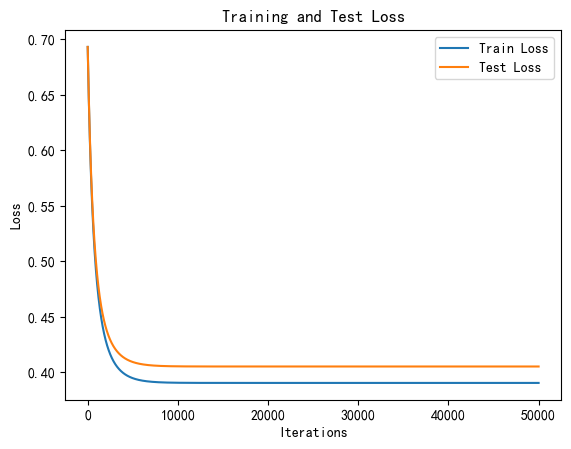

In [10]:
# 绘制训练集和测试集的平均损失曲线
plt.plot(np.mean(train_losses, axis=0), label='Train Loss')
plt.plot(np.mean(test_losses, axis=0), label='Test Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()

# model testing

In [11]:
y_train_pred

[array([[False],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [False]]),
 array([[ True],
        [ True],
        [ True],
        [False],
        [False],
        [False],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True]]),
 array([[ True],
        [False],
        [ True],
        [False],
        [False],
        [ True],
        [False],
        [ True],
        [False],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [ True],
        [ True],
        [False],
        [ True],
        [ 

In [12]:
y_test_pred

[array([[False],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [False],
        [ True],
        [ True],
        [False],
        [ True],
        [False],
        [False],
        [ True],
        [False],
        [ True],
        [False],
        [ True],
        [False],
        [False],
        [False],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [False],
        [False],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [False],
        [False],
        [False],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [ True],
        [ True],
        [False

# model evaluation

In [13]:
# 计算平均指标
mean_tpr_train /= kfold.get_n_splits(X)
mean_tpr_test /= kfold.get_n_splits(X)

f = pd.DataFrame([
    ['precision', np.mean(train_precisions), np.mean(test_precisions)],
    ['recall', np.mean(train_recalls), np.mean(test_recalls)],
    ['F1_score', np.mean(train_f1_scores), np.mean(test_f1_scores)],
    ['AUC', np.mean(train_auc_scores), np.mean(test_auc_scores)]
], columns=['', 'train data', 'test data'])


In [14]:
f

,,train data,test data
0,precision,0.954352,0.899206
1,recall,0.784022,0.762213
2,F1_score,0.860563,0.816021
3,AUC,0.971554,0.951448


Text(0, 0.5, 'TPR')

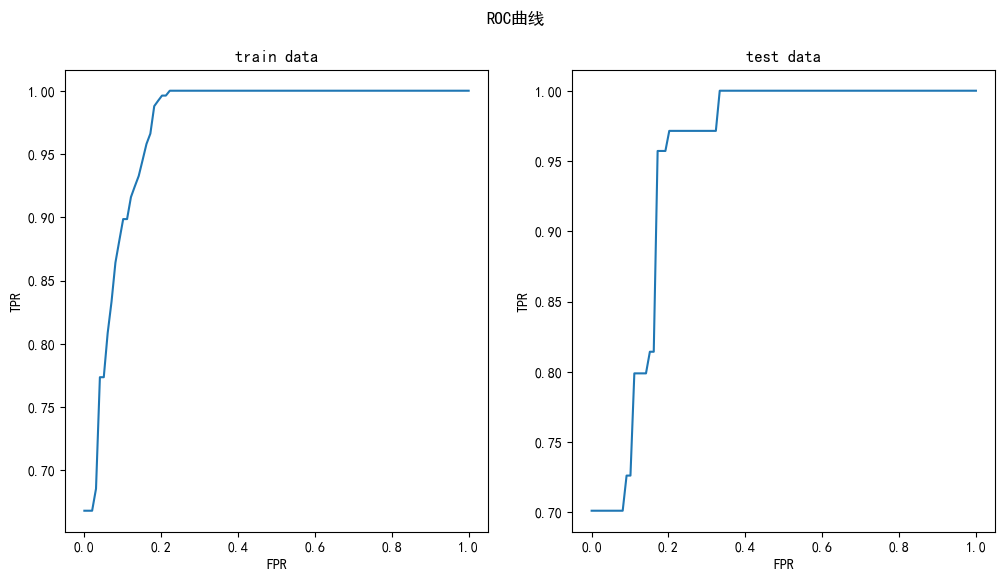

In [17]:
plt.figure(figsize = (12,6) )
plt.subplot(1,2,1)
plt.suptitle('ROC曲线')
plt.plot(fpr_grid,mean_tpr_train)
plt.title('train data')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.subplot(1,2,2)
plt.suptitle('ROC曲线')
plt.plot(fpr_grid,mean_tpr_test)
plt.title('test data')
plt.xlabel('FPR')
plt.ylabel('TPR')